In [1]:
import torch.optim as optim
import torch.nn as nn
from qiskit.providers.fake_provider import FakeLima
from scripts.data_setup import load_data
from scripts.from_circ_to_numpy import operations_to_features, save_to_json, load_from_json
from scripts.model import create_models, train_and_test_step, save_models, load_models
from qiskit import transpile
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from scripts.utils import get_backend_properties_v1
from scripts.mlp import MLP1, MLP2, MLP3, encode_data

import matplotlib.pyplot as plt
import seaborn as sns
from scripts.noise_utils import AddNoise, RemoveReadoutErrors
from scripts.mlp import recursive_dict_loop, count_gates_by_rotation_angle
from scripts.mbd_utils import calc_imbalance
import torch
from torch import nn
from sklearn import datasets
import sklearn
from scripts.utils import circuit_to_graph_data_json
from scripts.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
)
from qiskit.circuit.random import random_circuit
from sklearn.model_selection import train_test_split
from qiskit.converters import circuit_to_dag
from scripts.data_setup import load_data
from scripts.gate_dict_script import gate_dict_method
from scripts.from_circ_to_numpy import operations_to_features
from tqdm.auto import tqdm
from scripts.model import *

In [2]:
n_qubits = 5 # 5 == n_qubits, default value for now because of FakeLima
train_circuits, train_observables, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_observables, test_ideal_exp_vals, test_noisy_exp_vals = load_data('data/circuits/data_test_deeper_1_1')

In [3]:
backend = FakeLima()

In [4]:
X_train, y_train, X_test, y_test = load_from_json('data/features/data_test_deeper_1_1')

In [6]:
# specify these :)
sequence_input_size = 7
sequence_hidden_size = 4
sequence_num_layers = 4
sequence_model_type = 'LSTM'
sequence_dropout = 0.1
ann_hidden_layers = 4
ann_hidden_units = 32
ann_dropout = 0
noisy_first = True

sequence_model, ann = create_models(sequence_input_size, 
                                    sequence_hidden_size, 
                                    sequence_num_layers, 
                                    sequence_model_type, 
                                    sequence_dropout, 
                                    ann_hidden_layers, 
                                    ann_hidden_units, 
                                    ann_dropout, 
                                    noisy_first=noisy_first)

sequence_config = { 
    "input_size": sequence_input_size,
    "hidden_size": sequence_hidden_size,
    "num_layers": sequence_num_layers,
    "model_type": sequence_model_type,
    "dropout": sequence_dropout
}

ann_config = {
    "hidden_layers": ann_hidden_layers,
    "hidden_units": ann_hidden_units,
    "dropout": ann_dropout,
    "noisy_first": noisy_first
}

In [7]:
loss_fn = nn.MSELoss() # leave for now
optimizer = optim.Adam(list(ann.parameters()) + list(sequence_model.parameters()), lr=0.0001)

num_epochs = 5
train_and_test_step(sequence_model, ann, loss_fn, optimizer, X_train, train_noisy_exp_vals, y_train, X_test, test_noisy_exp_vals, y_test, num_epochs, noisy_first=noisy_first)

Epoch 1/5, train loss (PyTorch): 2.3479, test_loss (scikitlearn rmse): 1.7902
Epoch 2/5, train loss (PyTorch): 0.9970, test_loss (scikitlearn rmse): 0.7119
Epoch 3/5, train loss (PyTorch): 0.5972, test_loss (scikitlearn rmse): 0.5428
Epoch 4/5, train loss (PyTorch): 0.4642, test_loss (scikitlearn rmse): 0.4716
Epoch 5/5, train loss (PyTorch): 0.4097, test_loss (scikitlearn rmse): 0.4448


([2.3479054649674063,
  0.9970475774789185,
  0.5971677972086663,
  0.4642090159076942,
  0.4096627575249878],
 [1.7901986837387085,
  0.711920440196991,
  0.5427839756011963,
  0.4715970754623413,
  0.44484904408454895])

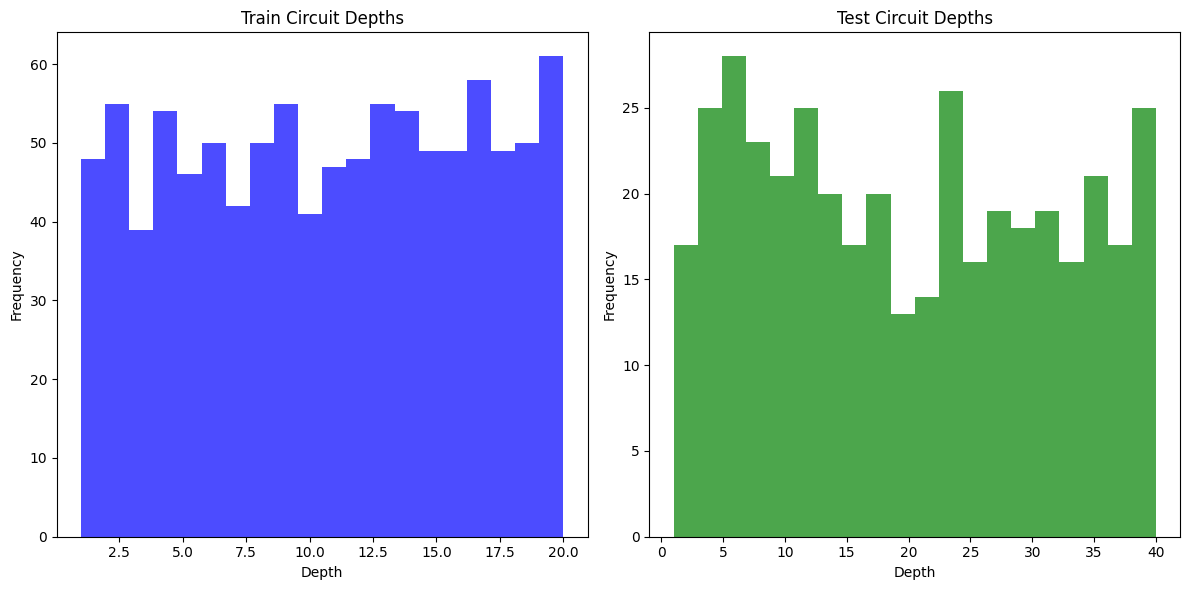

In [8]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

train_depths = [circuit.depth() for circuit in train_circuits]
test_depths = [circuit.depth() for circuit in test_circuits]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_depths, bins=20, color='blue', alpha=0.7)
plt.title('Train Circuit Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_depths, bins=20, color='green', alpha=0.7)
plt.title('Test Circuit Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


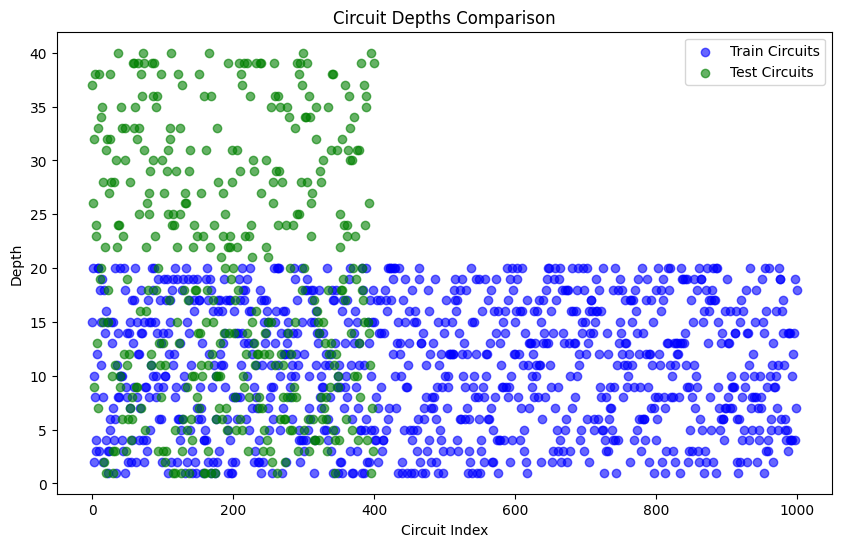

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit

train_depths = [circuit.depth() for circuit in train_circuits]
test_depths = [circuit.depth() for circuit in test_circuits]

plt.figure(figsize=(10, 6))

plt.scatter(range(len(train_depths)), train_depths, color='blue', label='Train Circuits', alpha=0.6)
plt.scatter(range(len(test_depths)), test_depths, color='green', label='Test Circuits', alpha=0.6)
plt.title('Circuit Depths Comparison')
plt.xlabel('Circuit Index')
plt.ylabel('Depth')
plt.legend()

plt.show()


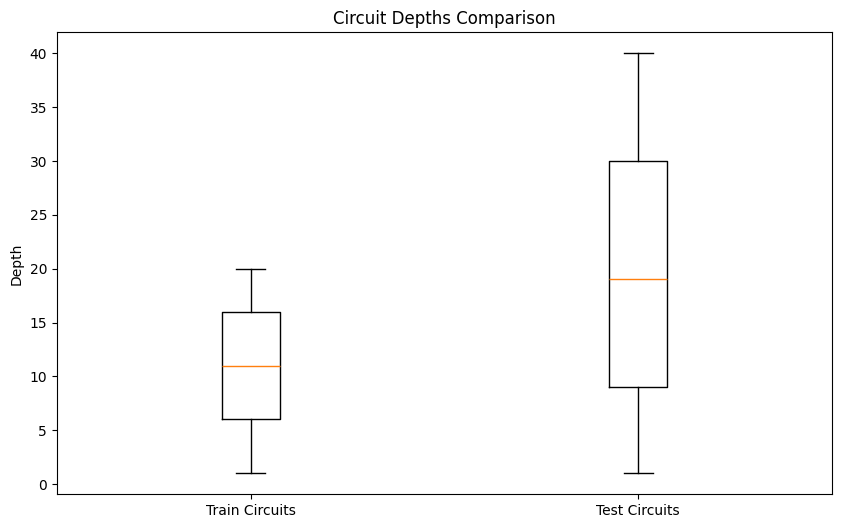

In [10]:
plt.figure(figsize=(10, 6))

plt.boxplot([train_depths, test_depths], labels=['Train Circuits', 'Test Circuits'])
plt.title('Circuit Depths Comparison')
plt.ylabel('Depth')

plt.show()


In [11]:
backend = FakeLima()
n_qubits = 5

In [12]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [13]:
properties = get_backend_properties_v1(backend=backend)

In [14]:
def encode_data(circuits, properties, ideal_exp_vals, noisy_exp_vals, num_qubits, meas_bases=None):
    # if isinstance(noisy_exp_vals[0], list) and len(noisy_exp_vals[0]) == 1:
    #     noisy_exp_vals = [x[0] for x in noisy_exp_vals]

    gates_set = sorted(properties['gates_set'])     # must sort!

    if meas_bases is None:
        meas_bases = [[]]

    vec = [np.mean(recursive_dict_loop(properties, out=[], target_key1='cx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='id', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='sx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='x', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='rz', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='readout_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t1'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t2'))]
    vec = torch.tensor(vec) * 100  # put it in the same order of magnitude as the expectation values

    bin_size = 0.1 * np.pi
    num_angle_bins = int(np.ceil(4 * np.pi / bin_size))

    X = torch.zeros([len(circuits), len(vec) + len(gates_set) + num_angle_bins + num_qubits + len(meas_bases[0])])

    vec_slice = slice(0, len(vec))
    gate_counts_slice = slice(len(vec), len(vec)+len(gates_set))
    angle_bins_slice = slice(len(vec)+len(gates_set), len(vec)+len(gates_set)+num_angle_bins)
    exp_val_slice = slice(len(vec)+len(gates_set)+num_angle_bins, len(vec)+len(gates_set)+num_angle_bins+num_qubits)
    meas_basis_slice = slice(len(vec)+len(gates_set)+num_angle_bins+num_qubits, len(X[0]))

    X[:, vec_slice] = vec[None, :]

    for i, circ in enumerate(circuits):
        gate_counts_all = circ.count_ops()
        X[i, gate_counts_slice] = torch.tensor(
            [gate_counts_all.get(key, 0) for key in gates_set]
        ) * 0.01  # put it in the same order of magnitude as the expectation values

    for i, circ in enumerate(circuits):
        gate_counts = count_gates_by_rotation_angle(circ, bin_size)
        X[i, angle_bins_slice] = torch.tensor(gate_counts) * 0.01  # put it in the same order of magnitude as the expectation values

        # if num_qubits > 1: assert len(noisy_exp_vals[i]) == num_qubits
        # elif num_qubits == 1: assert isinstance(noisy_exp_vals[i], float)

        X[i, exp_val_slice] = torch.tensor(noisy_exp_vals[i])

    if meas_bases != [[]]:
        assert len(meas_bases) == len(circuits)
        for i, basis in enumerate(meas_bases):
            X[i, meas_basis_slice] = torch.tensor(basis)

    y = torch.tensor(ideal_exp_vals, dtype=torch.float32)

    return X, y


In [15]:
X_train_rf, y_train_rf = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=n_qubits)
X_test_rf, y_test_rf = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=n_qubits)
BATCH_SIZE = 32
fix_random_seed(42)
train_dataset = TensorDataset(torch.Tensor(X_train_rf), torch.Tensor(y_train_rf))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test_rf), torch.Tensor(y_test_rf))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 42


In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=300)

In [17]:
from sklearn.metrics import root_mean_squared_error

In [18]:
y_pred_rf = rfr.predict(X_test_rf)
rms = root_mean_squared_error(y_test_rf, y_pred_rf)
rms

0.4560060281984203

In [19]:
root_mean_squared_error(test_ideal_exp_vals, test_noisy_exp_vals)

0.4709629870569579

In [20]:
y_pred_seqann = []
for i in range(len(X_test)):
    with torch.inference_mode():
        y_pred_seqann.append(run_models(sequence_model, ann, X_test[i], test_noisy_exp_vals[i], True).detach().numpy())

In [21]:
root_mean_squared_error(test_ideal_exp_vals, y_pred_seqann)

0.44484904637062656